In [ ]:
#I created a pretrained model, let's load it in and see if what it's doing is correct!

In [1]:
#we'll use all the same settings, based on my evaluation_utils_enformer script, but loaded in manually
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
import src.dataloaders.datasets.enformer_dataset as enformer_dataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

#let's find it
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-09-11/09-10-36-679751/checkpoints/last.ckpt'
model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
cfg = OmegaConf.create(cfg)
cfg = OmegaConf.to_container(cfg, resolve=True)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
split = 'test'

In [2]:
dataset_args = cfg['dataset']
dataset_args

{'_name_': 'KmerPretrainLoader',
 'bed_file': None,
 'fasta_file': None,
 'dataset_name': 'KmerPretrainLoader',
 'tokenizer_name': 'char',
 'cache_dir': None,
 'max_length': 196608,
 'add_eos': False,
 'batch_size': 1,
 'batch_size_eval': 2,
 'num_workers': 4,
 'shuffle': True,
 'pin_memory': True,
 '__train_len': 5087,
 '__l_max': 196608,
 'max_length_val': 196608,
 'max_length_test': 196608,
 'pad_max_length': None,
 'rc_aug': False,
 'use_fixed_len_val': False,
 'replace_N_token': False,
 'pad_interval': False,
 'kmer_len': 6,
 'mlm': True,
 'mlm_probability': 0.15}

In [3]:
dataset_args = cfg['dataset']
import src.dataloaders.datasets.kmer_pretrain_dataset as kmer_pretrain_dataset
dataset = kmer_pretrain_dataset.KmerPretrain(split, dataset_args['max_length'], tokenizer=None, rc_aug = dataset_args['rc_aug'], d_output=None,
                                                            mlm_probability=dataset_args['mlm_probability'],
                                                            kmer_len=dataset_args['kmer_len'], eligible_replacements=None) #could use dataloader instead, but again kinda complex

Using kmer genome with length 6


In [4]:
x,y=dataset[0]

In [5]:
print(x.shape, y.shape)

torch.Size([196608]) torch.Size([196608])


In [6]:
x[:100]

tensor([ 6341, 15628,  2290, 11451, 10380,  5644,  9518,   715,  3577,  2260,
        11300,  5997,  1250,  6250,     3,    15,    75,   375,  1876,  9381,
           30,   153,   765,  3827,  3511,  1931,  9658,  1416,  7080,  4153,
        15628, 10080,  3526,  2005, 10027, 15628,   686,  3430,  1526,  7633,
        15628,  3340,  1075,  5375,  4563,  9390,    76,   380,  1901,  9508,
          667,  3335,  1050,  5252, 10636,  6308,   292,  1461,  7306,  5280,
        10775,  7000, 15628,  3126,     5,    25,   128, 15628,  3208,   415,
         2078, 10391,  5082,  9788,  2068, 10343,  4843, 15628, 11711, 11681,
        11533, 10790,  7076,  4132,  5038,  9565, 13349,  4758,  8168,  9590,
         1078,  5391, 15628,  9775,  2001, 10008, 15628,   216,  1081,  5408])

In [7]:
y[:100]

tensor([15629,   458, 15629, 15629, 15629,  5028, 15629, 15629, 15629, 15629,
        15629,  9625, 15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629,
        15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629,
         5141, 15629, 15629, 15629, 15629,  3262, 15629, 15629, 15629, 15629,
         6918, 15629, 15629, 15629, 11253, 15629, 15629, 15629, 15629, 15629,
        15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629, 15629,
        15629, 15629,  3750, 15629, 15629, 15629, 15629,   641, 15629, 15629,
        15629, 15629, 15629, 15629, 15629, 15629, 15629,  8592, 15629, 15629,
        15629, 15629, 15629,  4132, 15629, 15629,   951, 15629, 15629, 15629,
        15629, 15629, 11330, 15629, 15629, 15629,  3168, 15629, 15629, 15629])

In [8]:
#now load in the model and test things with x and y!
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys() #includes lm head weight, so it's the whole thing

odict_keys(['train_torchmetrics.num_tokens.count', 'val_torchmetrics.num_tokens.count', 'test_torchmetrics.num_tokens.count', 'caduceus.backbone.embeddings.word_embeddings.complement_map', 'caduceus.backbone.embeddings.word_embeddings.embedding.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.A_log', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.D', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.conv1d.bias', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.conv1d.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.dt_proj.bias', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.dt_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.in_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.out_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_fwd.x_proj.weight', 'caduceus.backbone.layers.0.mixer.submodule.mamba_rev.A_log', 'caduceus.backbone.layers.0.mixer.submodule.mamba_rev.D', 'caduceus.backb

In [9]:
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

In [10]:
cfg['model']['config'].pop('_target_')
cfg['model']['config']['complement_map'] = dataset.tokenizer.complement_map
caduceus_cfg = CaduceusConfig(**cfg['model']['config'])

In [11]:
#now we have to load in the model, it's not just the backbone
#I think it's caduceus for masked lm?
from caduceus.modeling_caduceus import CaduceusForMaskedLM
model = CaduceusForMaskedLM(config=caduceus_cfg)

In [12]:
model

CaduceusForMaskedLM(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(15632, 256)
        )
      )
      (layers): ModuleList(
        (0-9): 10 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
                (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
                (act): SiLU()
                (x_proj): Linear(in_features=512, out_features=48, bias=False)
                (dt_proj): Linear(in_features=16, out_features=512, bias=True)
                (out_proj): Linear(in_features=512, out_features=256, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
                (co

In [13]:
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [14]:
#ok that actually worked? let's put X into the model
device = 'cuda'
model.eval()
model = model.to(device)
with torch.no_grad():
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
    x = x.to(device)
    y = y.to(device)
    output = model(x)

In [16]:
#so this is the full output of the model
output

MaskedLMOutput(loss=None, logits=tensor([[[ 8.0766,  8.5079,  9.0000,  ..., -5.1261, -3.2036, -4.1025],
         [ 8.4685, 10.1660,  7.1920,  ..., -6.4935, -6.6539, -7.1757],
         [ 6.5846,  2.2227,  4.4696,  ..., -3.4821, -3.3214, -1.1664],
         ...,
         [-0.2734,  1.1197,  8.0482,  ...,  1.8388,  0.4382,  1.3390],
         [ 9.5767,  3.7154,  4.0232,  ..., -3.9732, -3.2254, -1.7098],
         [ 7.5978,  1.8776, -2.5554,  ..., -5.5587, -2.7368, -4.7131]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [17]:
output.logits.shape #for each of the points we basically get a probability

torch.Size([1, 196608, 15632])

In [19]:
torch.sum(output.logits, dim=-1) #summing over the last dimension, we get the probability of each point

tensor([[-40562.4023, -70612.1016, -20235.5781,  ...,   6733.6182,
         -35315.5352, -40574.1133]], device='cuda:0')

In [20]:
#we haven't yet done softmax yet that's the real issue
#let's apply softmax
softmaxed = torch.nn.functional.softmax(output.logits, dim=-1)
softmaxed.shape

torch.Size([1, 196608, 15632])

In [21]:
#now sum
torch.sum(softmaxed, dim=-1) #this seems about correct

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0')

In [22]:
import torch.nn.functional as F
def cross_entropy(logits, y, ignore_index=-100):
    """Cross entropy loss."""
    logits = logits.view(-1, logits.shape[-1])
    y = y.view(-1)
    return F.cross_entropy(logits, y, ignore_index=ignore_index) #ignore index is telling it to ignore non masked values

In [23]:
loss = cross_entropy(output.logits, y, ignore_index=15629)
loss

tensor(6.6700e-05, device='cuda:0')

In [24]:
#ok so that's the overall loss, but let's back this up a bit
#set reduction to none
templogits = output.logits.view(-1, output.logits.shape[-1])
tempy = y.view(-1)
losses = F.cross_entropy(templogits, tempy, ignore_index=15629, reduction='none')
losses.shape

torch.Size([196608])

In [26]:
y.squeeze()

tensor([15629,   458, 15629,  ..., 15629, 15629, 15629], device='cuda:0')

In [25]:
losses #where it's masked we don't even compute a loss! Where it is masked, we use the probability distribution to find what's up

tensor([0.0000, 0.0342, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [27]:
output.logits[0,1,:] #the variouis values

tensor([ 8.4685, 10.1660,  7.1920,  ..., -6.4935, -6.6539, -7.1757],
       device='cuda:0')

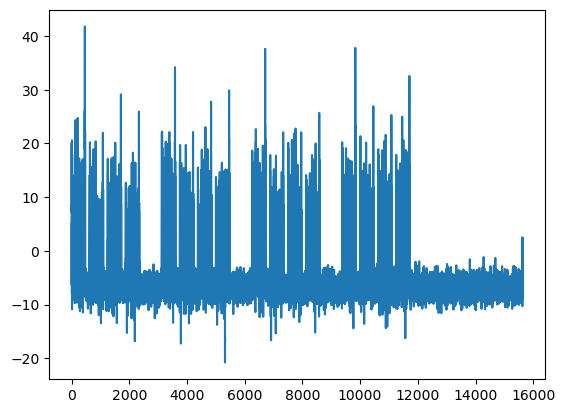

In [28]:
#let's plot it
plt.plot(output.logits[0,1,:].cpu().numpy())

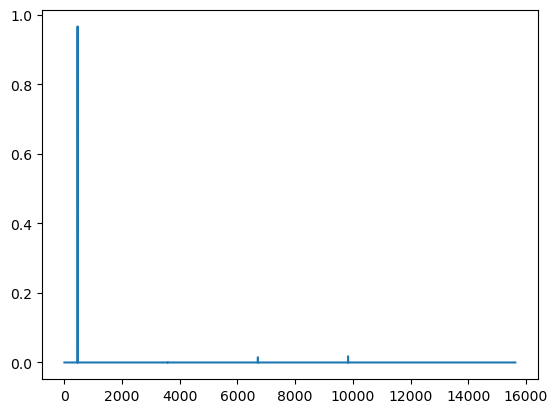

In [29]:
#and it softmaxed
plt.plot(softmaxed[0,1,:].cpu().numpy()) #clealry only one value is even considered

In [31]:
#the right answer is 458, let's see if it's the correct one
#find the max index
max_index = torch.argmax(softmaxed[0,1,:])
max_index #yes indeed it is, so the model works and gets it correct and doesn't see the 458...

tensor(458, device='cuda:0')

In [ ]:
#oh my god I'm such an idiot. No wonder the perplexity is 1... we're doing overlapping kmers...